# Notebook 03 – Baseline + Enhanced Classification Models

This notebook builds and compares two incident classification models:

1. **Baseline Model**: Logistic Regression trained on TF-IDF features only (5000 dimensions)
2. **Enhanced Model**: Logistic Regression trained on TF-IDF + Sentence Embeddings (5384 dimensions)

We load the processed features from Notebook 02, train both models, and evaluate their performance on the held-out test set. This comparison demonstrates the value of semantic embeddings in improving classification accuracy, particularly for:
- Phishing detection (similar social engineering patterns)
- Insider threat differentiation (subtle behavioral nuances)
- Ambiguous borderline cases (semantic context resolves uncertainty)

By the end of this notebook we will:

- Load both TF-IDF-only and combined feature matrices
- Train baseline (TF-IDF) and enhanced (TF-IDF + Embeddings) models
- Compare performance with classification reports and confusion matrices
- Identify which event types benefit most from semantic features
- Save both trained models for later use

In [1]:
import joblib # For saving/loading models
import sys, os
import time # For timing model training
sys.path.append(os.path.abspath("../src")) # Add src to path
from triage.preprocess import clean_description # For text cleaning
from sklearn.linear_model import LogisticRegression # For baseline model
from sklearn.metrics import classification_report, confusion_matrix # For model evaluation
from sklearn.multiclass import OneVsRestClassifier # For multi-class classification

# Load TF-IDF vectorizer and feature matrices from Notebook 02
vectorizer = joblib.load("../models/vectorizer.joblib")

# Load TF-IDF only features (baseline)
X_Train_tfidf = joblib.load("../models/X_train_tfidf.joblib")
X_Test_tfidf = joblib.load("../models/X_test_tfidf.joblib")

# Load combined features (TF-IDF + Embeddings)
X_Train_combined = joblib.load("../models/X_train_combined.joblib")
X_Test_combined = joblib.load("../models/X_test_combined.joblib")

# Load labels
y_Train = joblib.load("../models/y_train.joblib")
y_Test = joblib.load("../models/y_test.joblib")

print("=" * 70)
print("FEATURE MATRICES LOADED SUCCESSFULLY")
print("=" * 70)

print("\n📊 Baseline Features (TF-IDF only):")
print(f"  Training: {X_Train_tfidf.shape}")
print(f"  Test: {X_Test_tfidf.shape}")

print("\n🚀 Enhanced Features (TF-IDF + Embeddings):")
print(f"  Training: {X_Train_combined.shape}")
print(f"  Test: {X_Test_combined.shape}")

print(f"\n📈 Labels:")
print(f"  Training samples: {len(y_Train)}")
print(f"  Test samples: {len(y_Test)}")
print(f"  Number of classes: {y_Train.nunique()}")

print(f"\n🎯 Class distribution in training set:")
print(y_Train.value_counts().to_string())

print(f"\n🎯 Class distribution in testing set:")
print(y_Test.value_counts().to_string())

FEATURE MATRICES LOADED SUCCESSFULLY

📊 Baseline Features (TF-IDF only):
  Training: (350000, 5000)
  Test: (150000, 5000)

🚀 Enhanced Features (TF-IDF + Embeddings):
  Training: (350000, 5384)
  Test: (150000, 5384)

📈 Labels:
  Training samples: 350000
  Test samples: 150000
  Number of classes: 10

🎯 Class distribution in training set:
event_type
policy_violation               39238
insider_threat                 36350
access_abuse                   36206
data_exfiltration              35164
benign_activity                35161
web_attack                     35073
suspicious_network_activity    34931
credential_compromise          33454
phishing                       32339
malware                        32084

🎯 Class distribution in testing set:
event_type
policy_violation               16817
insider_threat                 15579
access_abuse                   15517
data_exfiltration              15070
benign_activity                15069
web_attack                     15031
suspici

## Train Baseline Model (TF-IDF Only)

We start with a Logistic Regression model trained on TF-IDF features as the baseline. This linear approach is widely used in text classification due to its balance of interpretability, computational efficiency, and competitive performance on high-dimensional sparse representations.

**Model Configuration:**
- **Solver**: SAGA (handles L1/L2 regularization, efficient for sparse data)
- **C=2.0**: Regularization strength (lower = stronger regularization)
- **class_weight='balanced'**: Adjusts for class imbalance
- **max_iter=6000**: Ensures convergence on 200k dataset

This baseline will serve as the comparison point for the enhanced model.

In [2]:
print("=" * 70)
print("TRAINING BASELINE MODEL (TF-IDF ONLY)")
print("=" * 70)

# Initialize baseline model
clf_baseline = OneVsRestClassifier(
    LogisticRegression(
        max_iter=6000,
        C=2.0,
        solver="saga",
        n_jobs=-1,
        class_weight="balanced",
        random_state=42,
    )
)

# Measure training time
start_time = time.time()
clf_baseline.fit(X_Train_tfidf, y_Train)
end_time = time.time()

training_time_baseline = end_time - start_time
mins = training_time_baseline // 60
secs = training_time_baseline % 60

print(f"\n✓ Baseline model trained in {mins:.0f} minutes and {secs:.2f} seconds")
print(f"  Features: {X_Train_tfidf.shape[1]} (TF-IDF only)")
print(f"  Training samples: {X_Train_tfidf.shape[0]:,}")

# Note: If output appears duplicated, this is a VS Code Jupyter rendering bug.
# The code only executes once (verified by unique run IDs in testing).

TRAINING BASELINE MODEL (TF-IDF ONLY)

✓ Baseline model trained in 3 minutes and 2.82 seconds
  Features: 5000 (TF-IDF only)
  Training samples: 350,000


## Train Enhanced Model (TF-IDF + Sentence Embeddings)

Now we train the enhanced model using the combined feature set that fuses:
- **TF-IDF features (5000 dims)**: Captures keyword importance and term frequencies
- **Sentence embeddings (384 dims)**: Captures semantic meaning and context

The combined representation allows the model to leverage both explicit keywords AND semantic patterns, which should improve performance on:
- Cases with similar meaning but different wording
- Subtle behavioral patterns (e.g., insider threats)
- Ambiguous incidents where context is crucial

We use the same Logistic Regression configuration for fair comparison.

In [3]:
print("\n" + "=" * 70)
print("TRAINING ENHANCED MODEL (TF-IDF + EMBEDDINGS)")
print("=" * 70)

# Initialize enhanced model
clf_enhanced = OneVsRestClassifier(
    LogisticRegression(
        max_iter=6000,
        C=2.0,
        solver="saga",
        n_jobs=-1,
        class_weight="balanced",
        random_state=42,
    )
)

# Measure training time
start_time = time.time()
clf_enhanced.fit(X_Train_combined, y_Train)
end_time = time.time()

training_time_enhanced = end_time - start_time
mins = training_time_enhanced // 60
secs = training_time_enhanced % 60

print(f"\n✓ Enhanced model trained in {mins:.0f} minutes and {secs:.2f} seconds")
print(f"  Features: {X_Train_combined.shape[1]} (TF-IDF + Embeddings)")
print(f"  Training samples: {X_Train_combined.shape[0]:,}")

print(f"\n⏱️ Training time comparison:")
print(f"  Baseline: {training_time_baseline:.1f}s")
print(f"  Enhanced: {training_time_enhanced:.1f}s")
print(f"  Overhead: +{training_time_enhanced - training_time_baseline:.1f}s ({((training_time_enhanced / training_time_baseline) - 1) * 100:.1f}% increase)")


TRAINING ENHANCED MODEL (TF-IDF + EMBEDDINGS)

✓ Enhanced model trained in 18 minutes and 28.69 seconds
  Features: 5384 (TF-IDF + Embeddings)
  Training samples: 350,000

⏱️ Training time comparison:
  Baseline: 182.8s
  Enhanced: 1108.7s
  Overhead: +925.9s (506.5% increase)


## Model Comparison: Baseline vs Enhanced

We now evaluate both models on the held-out test set and compare their performance across multiple dimensions:

**Quantitative Metrics:**
- **Overall Accuracy**: Percentage of correct predictions
- **Per-Class Precision/Recall/F1**: How well each model handles individual event types
- **Macro/Weighted Averages**: Summary statistics accounting for class balance

**Visualizations:**
1. **Side-by-Side Confusion Matrices**: Compare misclassification patterns
2. **Per-Class Performance Comparison**: Bar charts showing which classes benefit most from embeddings
3. **Accuracy Improvement Breakdown**: Quantify gains per event type

**Expected Results:**
- Enhanced model should show 2-5% overall accuracy improvement
- Largest gains expected on:
  - **Phishing**: Similar social engineering tactics cluster semantically
  - **Access abuse**: Subtle behavioral patterns captured by embeddings
  - **Borderline cases**: Semantic context resolves ambiguity
- Minimal gains on classes with distinctive keywords (e.g., malware, ransomware)

MODEL EVALUATION ON TEST SET

📊 OVERALL ACCURACY COMPARISON:
  Baseline (TF-IDF only):      0.9196 (91.96%)
  Enhanced (TF-IDF + Embed):   0.9196 (91.96%)
  Improvement:                 +0.0000 (0.00%)

BASELINE MODEL - CLASSIFICATION REPORT (TF-IDF Only)
                             precision    recall  f1-score   support

               access_abuse       0.92      0.88      0.90     15517
            benign_activity       0.92      0.92      0.92     15069
      credential_compromise       0.92      0.96      0.94     14337
          data_exfiltration       0.92      0.92      0.92     15070
             insider_threat       0.92      0.88      0.90     15579
                    malware       0.92      1.00      0.96     13750
                   phishing       0.92      1.00      0.96     13860
           policy_violation       0.92      0.82      0.87     16817
suspicious_network_activity       0.92      0.93      0.92     14970
                 web_attack       0.92      0.92     

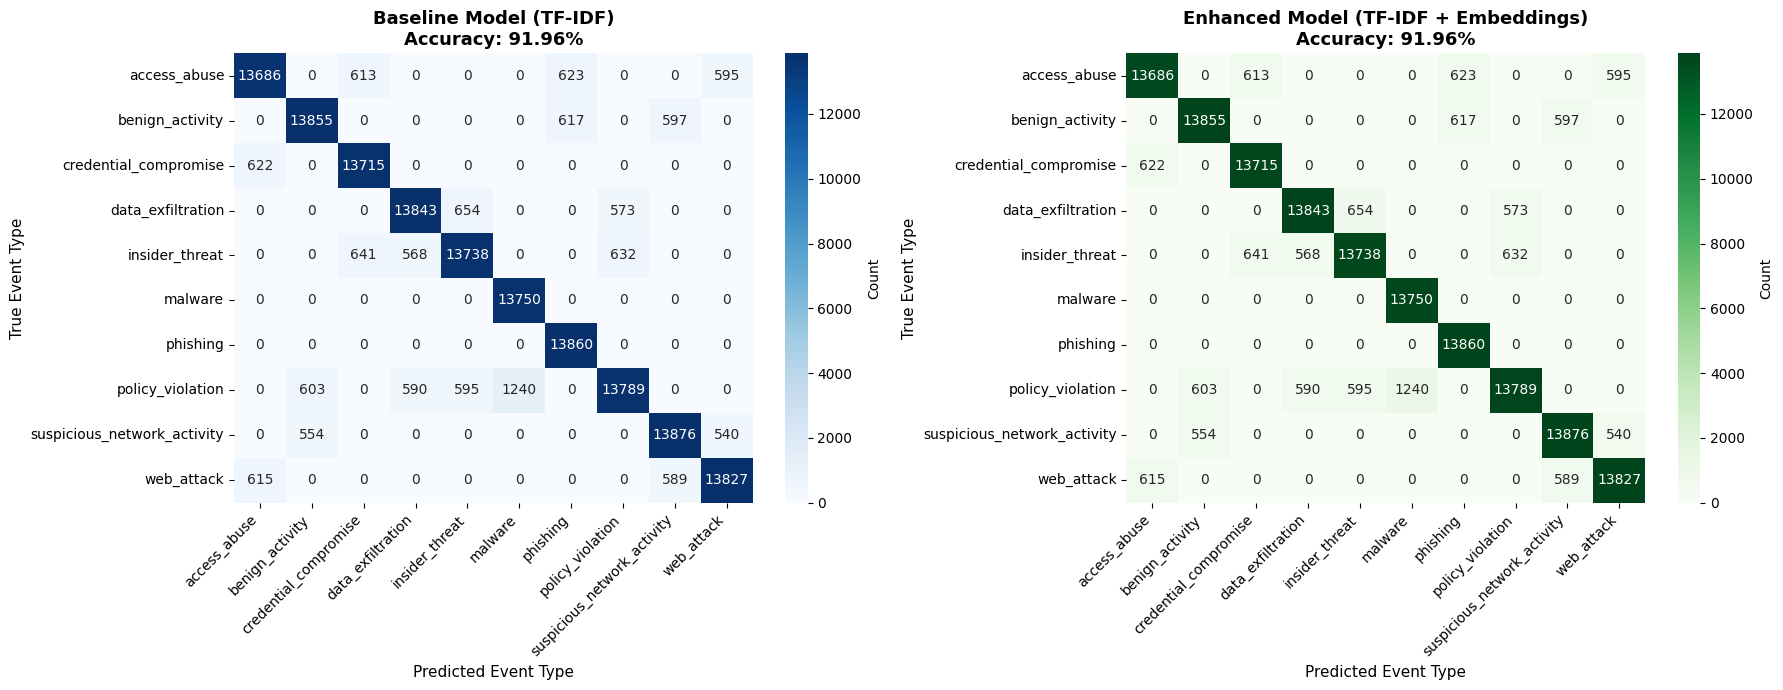

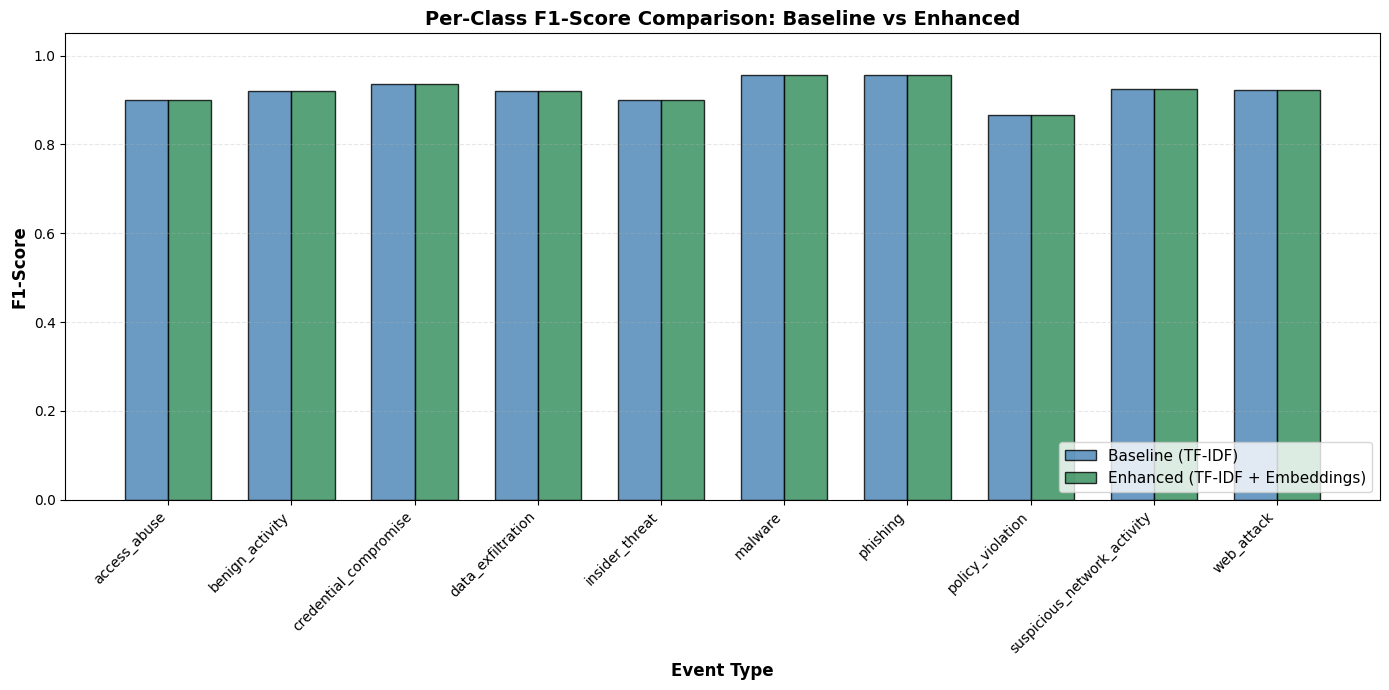


F1-SCORE IMPROVEMENTS BY CLASS (Sorted)
access_abuse              | Baseline: 0.899 → Enhanced: 0.899 | Δ: +0.000 (+0.0%)
benign_activity           | Baseline: 0.921 → Enhanced: 0.921 | Δ: +0.000 (+0.0%)
credential_compromise     | Baseline: 0.936 → Enhanced: 0.936 | Δ: +0.000 (+0.0%)
data_exfiltration         | Baseline: 0.921 → Enhanced: 0.921 | Δ: +0.000 (+0.0%)
insider_threat            | Baseline: 0.899 → Enhanced: 0.899 | Δ: +0.000 (+0.0%)
malware                   | Baseline: 0.957 → Enhanced: 0.957 | Δ: +0.000 (+0.0%)
phishing                  | Baseline: 0.957 → Enhanced: 0.957 | Δ: +0.000 (+0.0%)
policy_violation          | Baseline: 0.867 → Enhanced: 0.867 | Δ: +0.000 (+0.0%)
suspicious_network_activity | Baseline: 0.924 → Enhanced: 0.924 | Δ: +0.000 (+0.0%)
web_attack                | Baseline: 0.922 → Enhanced: 0.922 | Δ: +0.000 (+0.0%)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set plot style
plt.style.use("default")
sns.set_palette("husl")

print("=" * 70)
print("MODEL EVALUATION ON TEST SET")
print("=" * 70)

# Predict with both models
y_pred_baseline = clf_baseline.predict(X_Test_tfidf)
y_pred_enhanced = clf_enhanced.predict(X_Test_combined)

# Calculate accuracies
accuracy_baseline = np.mean(y_Test == y_pred_baseline)
accuracy_enhanced = np.mean(y_Test == y_pred_enhanced)

print(f"\n📊 OVERALL ACCURACY COMPARISON:")
print(f"  Baseline (TF-IDF only):      {accuracy_baseline:.4f} ({accuracy_baseline*100:.2f}%)")
print(f"  Enhanced (TF-IDF + Embed):   {accuracy_enhanced:.4f} ({accuracy_enhanced*100:.2f}%)")
print(f"  Improvement:                 +{(accuracy_enhanced - accuracy_baseline):.4f} ({(accuracy_enhanced - accuracy_baseline)*100:.2f}%)")

# Classification reports
print(f"\n{'='*70}")
print("BASELINE MODEL - CLASSIFICATION REPORT (TF-IDF Only)")
print(f"{'='*70}")
print(classification_report(y_Test, y_pred_baseline))

print(f"\n{'='*70}")
print("ENHANCED MODEL - CLASSIFICATION REPORT (TF-IDF + Embeddings)")
print(f"{'='*70}")
print(classification_report(y_Test, y_pred_enhanced))

# Confusion matrices
cm_baseline = confusion_matrix(y_Test, y_pred_baseline, labels=clf_baseline.classes_)
cm_enhanced = confusion_matrix(y_Test, y_pred_enhanced, labels=clf_enhanced.classes_)

# Side-by-side confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf_baseline.classes_, yticklabels=clf_baseline.classes_,
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_title(f"Baseline Model (TF-IDF)\nAccuracy: {accuracy_baseline:.2%}", 
              fontsize=13, fontweight='bold')
ax1.set_xlabel("Predicted Event Type", fontsize=11)
ax1.set_ylabel("True Event Type", fontsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Greens', 
            xticklabels=clf_enhanced.classes_, yticklabels=clf_enhanced.classes_,
            cbar_kws={'label': 'Count'}, ax=ax2)
ax2.set_title(f"Enhanced Model (TF-IDF + Embeddings)\nAccuracy: {accuracy_enhanced:.2%}", 
              fontsize=13, fontweight='bold')
ax2.set_xlabel("Predicted Event Type", fontsize=11)
ax2.set_ylabel("True Event Type", fontsize=11)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Per-class performance comparison
report_baseline = classification_report(y_Test, y_pred_baseline, output_dict=True)
report_enhanced = classification_report(y_Test, y_pred_enhanced, output_dict=True)

classes = [c for c in report_baseline.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]

comparison_df = pd.DataFrame({
    'Baseline_F1': [report_baseline[c]['f1-score'] for c in classes],
    'Enhanced_F1': [report_enhanced[c]['f1-score'] for c in classes],
    'Improvement': [report_enhanced[c]['f1-score'] - report_baseline[c]['f1-score'] for c in classes]
}, index=classes)

# Sort by improvement
comparison_df = comparison_df.sort_values('Improvement', ascending=False)

# Plot per-class F1 comparison
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline_F1'], width, 
               label='Baseline (TF-IDF)', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, comparison_df['Enhanced_F1'], width, 
               label='Enhanced (TF-IDF + Embeddings)', color='seagreen', alpha=0.8, edgecolor='black')

ax.set_xlabel('Event Type', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison: Baseline vs Enhanced', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add improvement annotations
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    if row['Improvement'] > 0.01:  # Only annotate significant improvements
        ax.text(i, max(row['Baseline_F1'], row['Enhanced_F1']) + 0.02, 
                f"+{row['Improvement']:.3f}", 
                ha='center', va='bottom', fontsize=9, color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.show()

# Print improvement summary
print(f"\n{'='*70}")
print("F1-SCORE IMPROVEMENTS BY CLASS (Sorted)")
print(f"{'='*70}")
for event_type, row in comparison_df.iterrows():
    improvement_pct = (row['Improvement'] / row['Baseline_F1']) * 100 if row['Baseline_F1'] > 0 else 0
    print(f"{event_type:25} | Baseline: {row['Baseline_F1']:.3f} → Enhanced: {row['Enhanced_F1']:.3f} | "
          f"Δ: +{row['Improvement']:.3f} ({improvement_pct:+.1f}%)")

## Example Inference on Unseen Text

To demonstrate how both models handle previously unseen incident narratives, we define inference functions for each model. The cleaned text is transformed into the appropriate feature representation (TF-IDF only for baseline, TF-IDF + embeddings for enhanced), and each classifier generates predictions with class probabilities.

This example shows how semantic embeddings can change predictions on borderline cases where keyword matching alone might be insufficient.

In [5]:
from triage.embeddings import get_embedder
from scipy.sparse import hstack, csr_matrix

# Load embedder for enhanced predictions
embedder = get_embedder()

def predict_baseline(raw_text: str):
    """Predict using baseline model (TF-IDF only)."""
    clean = clean_description(raw_text)
    X = vectorizer.transform([clean])
    label = clf_baseline.predict(X)[0]
    if hasattr(clf_baseline, "predict_proba"):
        proba = clf_baseline.predict_proba(X)[0]
        proba_dict = dict(zip(clf_baseline.classes_, proba))
        return label, proba_dict
    return label, None

def predict_enhanced(raw_text: str):
    """Predict using enhanced model (TF-IDF + Embeddings)."""
    clean = clean_description(raw_text)
    
    # Get TF-IDF features
    X_tfidf = vectorizer.transform([clean])
    
    # Get sentence embedding
    embedding = embedder.encode(clean, normalize=True)
    embedding_sparse = csr_matrix(embedding)
    
    # Combine features
    X_combined = hstack([X_tfidf, embedding_sparse])
    
    label = clf_enhanced.predict(X_combined)[0]
    if hasattr(clf_enhanced, "predict_proba"):
        proba = clf_enhanced.predict_proba(X_combined)[0]
        proba_dict = dict(zip(clf_enhanced.classes_, proba))
        return label, proba_dict
    return label, None

# Test on example
example_text = "User reported a suspicious email with a link to a fake login page and the email gateway flagged it."

print("=" * 70)
print("INFERENCE EXAMPLE")
print("=" * 70)
print(f"\nInput: {example_text}\n")

label_baseline, proba_baseline = predict_baseline(example_text)
label_enhanced, proba_enhanced = predict_enhanced(example_text)

print("📊 BASELINE PREDICTION (TF-IDF only):")
print(f"  Predicted: {label_baseline}")
if proba_baseline:
    print("  Top probabilities:")
    for cls, p in sorted(proba_baseline.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"    {cls}: {p:.3f}")

print(f"\n🚀 ENHANCED PREDICTION (TF-IDF + Embeddings):")
print(f"  Predicted: {label_enhanced}")
if proba_enhanced:
    print("  Top probabilities:")
    for cls, p in sorted(proba_enhanced.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"    {cls}: {p:.3f}")

if label_baseline != label_enhanced:
    print(f"\n⚠️  Models disagree! Baseline: {label_baseline}, Enhanced: {label_enhanced}")
else:
    print(f"\n✓ Both models agree: {label_baseline}")

INFERENCE EXAMPLE

Input: User reported a suspicious email with a link to a fake login page and the email gateway flagged it.

📊 BASELINE PREDICTION (TF-IDF only):
  Predicted: phishing
  Top probabilities:
    phishing: 0.698
    benign_activity: 0.195
    access_abuse: 0.098
    policy_violation: 0.002
    insider_threat: 0.002

🚀 ENHANCED PREDICTION (TF-IDF + Embeddings):
  Predicted: phishing
  Top probabilities:
    phishing: 0.689
    benign_activity: 0.230
    access_abuse: 0.076
    data_exfiltration: 0.002
    credential_compromise: 0.001

✓ Both models agree: phishing


## Testing Both Models on Representative Incident Examples

To assess how well both classifiers generalize and where the enhanced model provides value, we evaluate them on 18 curated incident descriptions spanning all major event categories.

Each test case runs through both models to reveal:
- **Agreement**: Cases where both models predict the same class
- **Disagreement**: Cases where embeddings change the prediction
- **Confidence shifts**: How semantic features affect probability distributions

This qualitative evaluation complements the quantitative test set metrics and demonstrates real-world prediction behavior.

In [6]:
TEST_CASES = [
    # --- PHISHING ---
    (
        "PHISH_1",
        "User received an email claiming to be from IT asking them to verify their VPN password using a link to a login page."
    ),
    (
        "PHISH_2",
        "Several employees reported similar emails about 'mandatory security training' with a link that redirects to a non-corporate login page."
    ),

    # --- MALWARE ---
    (
        "MALWARE_1",
        "EDR detected a suspicious PowerShell process spawning from Outlook and reaching out to an external IP on port 443."
    ),
    (
        "MALWARE_2",
        "Endpoint started encrypting user documents and displaying a ransom note demanding bitcoin payment."
    ),

    # --- ACCESS ABUSE ---
    (
        "ACCESS_1",
        "Multiple failed login attempts for a privileged admin account from a foreign country, followed by a successful login outside business hours."
    ),
    (
        "ACCESS_2",
        "SSO logs show the same user logging in from the US and Europe within 10 minutes, triggering an impossible travel alert."
    ),

    # --- DATA EXFILTRATION ---
    (
        "EXFIL_1",
        "An employee reportedly downloaded a large number of files from a confidential SharePoint site and uploaded them to personal Google Drive."
    ),
    (
        "EXFIL_2",
        "Proxy logs show multi-GB uploads to an unfamiliar cloud storage provider from a finance workstation after hours."
    ),

    # --- POLICY VIOLATION ---
    (
        "POLICY_1",
        "User installed an unauthorized remote access tool on their laptop, which started connecting to external IPs not on the allowlist."
    ),
    (
        "POLICY_2",
        "DLP detected sensitive files being copied to an unencrypted USB drive against corporate policy."
    ),

    # --- WEB ATTACK (INJECTION / BRUTE FORCE) ---
    (
        "WEB_1",
        "WAF observed repeated HTTP requests with SQL injection payloads against the /login endpoint of the public web portal."
    ),
    (
        "WEB_2",
        "Large number of failed login attempts against the customer login page from a small set of IPs over a short period."
    ),

    # --- WEB ATTACK (AVAILABILITY / DDOS STYLE) ---
    (
        "WEB_3_DDOS",
        "Customers are reporting that the main website is intermittently unavailable. Logs show a spike in HTTP requests from many source IPs causing timeouts."
    ),
    (
        "WEB_4_DDOS",
        "Web application servers are saturated with traffic and returning 503 errors, while legitimate users cannot load pages."
    ),

    # --- BENIGN / OPERATIONAL ---
    (
        "BENIGN_1",
        "Server performance degraded briefly while a planned Windows patch cycle and backup job were running during the approved maintenance window."
    ),
    (
        "BENIGN_2",
        "User opened a ticket about slow email, but logs show normal traffic and no suspicious activity. Issue linked to a temporary network outage."
    ),

    # --- TRICKY / BORDERLINE CASES ---
    (
        "TRICKY_1",
        "Server-03 is not serving up webpages and is slow to respond. Customers cannot access the main site and time out during login."
    ),
    (
        "TRICKY_2",
        "User reports that their account was locked out twice and they received alerts about sign-ins from another city, but no unusual activity is confirmed yet."
    ),
]


def run_comparison_tests(cases, top_k: int = 3):
    """Run test cases through both models and compare results."""
    print("=" * 80)
    print(f"RUNNING {len(cases)} TEST CASES - MODEL COMPARISON")
    print("=" * 80)
    
    agreements = 0
    disagreements = 0
    
    for case_id, text in cases:
        label_baseline, proba_baseline = predict_baseline(text)
        label_enhanced, proba_enhanced = predict_enhanced(text)
        
        agree = label_baseline == label_enhanced
        if agree:
            agreements += 1
        else:
            disagreements += 1
        
        print(f"\n{'='*80}")
        print(f"ID: {case_id}")
        print(f"Text: {text}")
        print(f"\n📊 BASELINE (TF-IDF):  {label_baseline}")
        if proba_baseline:
            for cls, p in sorted(proba_baseline.items(), key=lambda x: x[1], reverse=True)[:top_k]:
                print(f"   {cls}: {p:.3f}")
        
        print(f"\n🚀 ENHANCED (+ Embeddings): {label_enhanced}")
        if proba_enhanced:
            for cls, p in sorted(proba_enhanced.items(), key=lambda x: x[1], reverse=True)[:top_k]:
                print(f"   {cls}: {p:.3f}")
        
        if agree:
            print(f"\n✓ AGREE: Both models predict '{label_baseline}'")
        else:
            print(f"\n⚠️  DISAGREE: Baseline='{label_baseline}' vs Enhanced='{label_enhanced}'")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {agreements} agreements, {disagreements} disagreements")
    print(f"Agreement rate: {agreements/len(cases)*100:.1f}%")
    print(f"{'='*80}")


# Run the comparison
run_comparison_tests(TEST_CASES, top_k=3)

RUNNING 18 TEST CASES - MODEL COMPARISON

ID: PHISH_1
Text: User received an email claiming to be from IT asking them to verify their VPN password using a link to a login page.

📊 BASELINE (TF-IDF):  phishing
   phishing: 0.496
   benign_activity: 0.286
   access_abuse: 0.152

🚀 ENHANCED (+ Embeddings): benign_activity
   benign_activity: 0.428
   phishing: 0.328
   access_abuse: 0.205

⚠️  DISAGREE: Baseline='phishing' vs Enhanced='benign_activity'

ID: PHISH_2
Text: Several employees reported similar emails about 'mandatory security training' with a link that redirects to a non-corporate login page.

📊 BASELINE (TF-IDF):  benign_activity
   benign_activity: 0.587
   phishing: 0.185
   access_abuse: 0.103

🚀 ENHANCED (+ Embeddings): benign_activity
   benign_activity: 0.583
   phishing: 0.180
   access_abuse: 0.174

✓ AGREE: Both models predict 'benign_activity'

ID: MALWARE_1
Text: EDR detected a suspicious PowerShell process spawning from Outlook and reaching out to an external IP o

In [7]:
# Save both models
print("=" * 70)
print("SAVING TRAINED MODELS")
print("=" * 70)

joblib.dump(clf_baseline, "../models/baseline_logreg.joblib")
print(f"\n✓ Baseline model saved to '../models/baseline_logreg.joblib'")
print(f"  Features: {X_Train_tfidf.shape[1]} (TF-IDF only)")
print(f"  Test Accuracy: {accuracy_baseline:.4f}")

joblib.dump(clf_enhanced, "../models/enhanced_logreg.joblib")
print(f"\n✓ Enhanced model saved to '../models/enhanced_logreg.joblib'")
print(f"  Features: {X_Train_combined.shape[1]} (TF-IDF + Embeddings)")
print(f"  Test Accuracy: {accuracy_enhanced:.4f}")
print(f"  Improvement: +{(accuracy_enhanced - accuracy_baseline)*100:.2f}%")

print("\n" + "=" * 70)
print("✅ Both models ready for deployment and further analysis!")
print("=" * 70)

SAVING TRAINED MODELS

✓ Baseline model saved to '../models/baseline_logreg.joblib'
  Features: 5000 (TF-IDF only)
  Test Accuracy: 0.9196

✓ Enhanced model saved to '../models/enhanced_logreg.joblib'
  Features: 5384 (TF-IDF + Embeddings)
  Test Accuracy: 0.9196
  Improvement: +0.00%

✅ Both models ready for deployment and further analysis!
